# 0. Setup

In [ ]:
!nvidia-smi -L

In [1]:
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from misc.helpers import find_model_weights, calculate_label_distributions, prev_img, prev_img_gray, trans_norm2tensor, find_csv_files, get_image_paths_from_csv, get_image_paths_from_dir, get_image_filenames_by_label, create_vit_model
from misc.visualization import *
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset import ViT
from utils.imageQualityDataset import ImageQualityDataset
from utils.imageAttentionGlobalAvgDataset import ImageAttentionGlobalAvgDataset



# 1. Build Model

In [2]:
image_size=256
patch_size=16
num_classes=5
depth = 6

In [3]:
model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from misc import transformations

# Load the images and apply the transformation
resize_crop = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(256)
            ])

In [5]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
img2tensor_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
# Define the transformation including normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
def preprocess_img_gray(img: Image.Image) -> Image.Image:
    """
    Process the image for previewing purposes with grayscale and contrast adjustment.

    This function applies transformations to resize and center crop the input image to a specified size.
    It then converts the image to grayscale and enhances the contrast by scaling the luminance values.
    
    Parameters:
    img (PIL.Image): The input image.

    Returns:
    img_bw_contrast_rgb (PIL.Image): The processed image with enhanced contrast in RGB format.
    """

    # Convert the image to grayscale
    img_bw = img.convert('L')

    # Convert grayscale image to YCbCr color space
    img_ycbcr = img_bw.convert('YCbCr')
    y, cb, cr = img_ycbcr.split()
    # Convert Y channel to NumPy arrays
    y_array = np.array(y)

    # Perform contrast adjustment on the Y component
    y_array = np.clip(y_array * 2.0, 0, 255).astype(np.uint8)

    # Merge the adjusted Y, Cb, Cr components back into an image
    img_bw_contrast = Image.merge('YCbCr', (Image.fromarray(y_array), cb, cr))

    # Convert the image back to RGB for display
    img_bw_contrast_rgb = img_bw_contrast.convert('RGB')
    
    return img_bw_contrast_rgb

In [7]:
# Get all Images of I5 class (example filename: 1691ILSVRC2013_train_00007339.JPEG_I5_Q60.jpeg)
# 1. Load the CSV file
csv_file = 'assets/Test/Obs0.csv'

# 2. Read the CSV file and store the image paths in a list
# Extract the directory path from the CSV file path
img_directory_path = 'assets/Test/DSX'

# Get the list of image paths from the CSV file
image_paths = get_image_filenames_by_label(csv_file, label=5, img_directory_path=img_directory_path)
print(image_paths)

weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'

weight_paths = find_model_weights(weights_dir) # Example path: 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO1.pth'


output_dir = 'results/Attention_maps/comparisons/blur_patches'

crop_size = (100,100)

img_idx = 54 # 50, 54

[]


In [8]:
# Initialize a list to store the image paths
image_paths = []

# Read the CSV file and extract the image filenames
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        image_filename = row[0]
        vote = row[1]
        # fitler only images with vote of 5
        if int(vote) == 5:
            image_path = os.path.join(img_directory_path, image_filename)
            image_paths.append(image_path)

print(image_paths[img_idx])


assets/Test/DSX\18833ILSVRC2013_train_00088514.JPEG_I5_Q72.jpeg


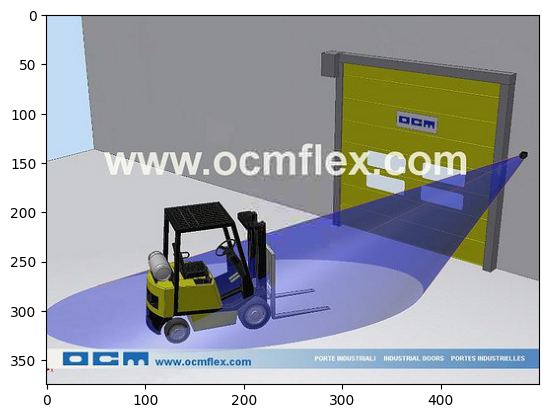

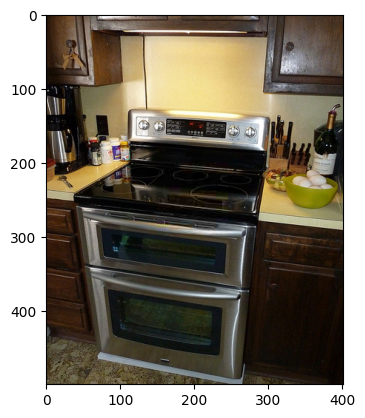

In [9]:
images = ["assets/Test/DSX/37344ILSVRC2014_train_00031300.JPEG_I5_Q88.jpeg", "assets/Test/DSX/31575ILSVRC2014_train_00030739.JPEG_I5_Q100.jpeg"]  # List of image file paths or PIL images
# images = image_paths
transform_func = transformations.apply_compression_patch  # or apply_blur_patch

for image in images:
    image = Image.open(image)
    transformed_image = transform_func(image, (100, 100), crop_pos='center')  # Apply the transformation function
    plt.imshow(transformed_image)  # Display the transformed image
    plt.show()

In [10]:
images_org = []
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image = resize_crop(image)
    images_org.append(image)

# Create Dataset (transform images, level 1-3)


In [ ]:
images_blurred_center = [transformations.apply_blur_patch(image, crop_size=crop_size, crop_pos='center') for image in images_org]
images_blurred_topleft = [transformations.apply_blur_patch(image, crop_size=crop_size, crop_pos='top-left') for image in images_org]
images_blurred_topright = [transformations.apply_blur_patch(image, crop_size=crop_size, crop_pos='top-right') for image in images_org]
images_blurred_bottomleft = [transformations.apply_blur_patch(image, crop_size=crop_size, crop_pos='bottom-left') for image in images_org]
images_blurred_bottomright = [transformations.apply_blur_patch(image, crop_size=crop_size, crop_pos='bottom-right') for image in images_org]

In [ ]:
images_compressed_lvl_1_center = [transformations.apply_compression_patch(image, crop_size=crop_size, quality=2 ,crop_pos='center' ) for image in images_org]
images_compressed_lvl_2_center = [transformations.apply_compression_patch(image, crop_size=crop_size, quality=11 ,crop_pos='center' ) for image in images_org]
images_compressed_lvl_3_center = [transformations.apply_compression_patch(image, crop_size=crop_size, quality=19 ,crop_pos='center' ) for image in images_org]


# plot sample image
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(images_org[img_idx])
axes[0].set_title('Original Image')
axes[1].imshow(images_compressed_lvl_1_center[img_idx])
axes[1].set_title('Compressed lvl 1 Image (Center)')
axes[2].imshow(images_compressed_lvl_2_center[img_idx])
axes[2].set_title('Compressed lvl 2 Image (Center)')
axes[3].imshow(images_compressed_lvl_3_center[img_idx])
axes[3].set_title('Compressed lvl 3 Image (Center)')
for ax in axes:
    ax.axis('off')
plt.show()

In [ ]:
# images compressed center
images_compressed_lvl_1_center = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=2 ,crop_pos='center' ) for image in images_org]
images_compressed_lvl_2_center = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=11 ,crop_pos='center' ) for image in images_org]
images_compressed_lvl_3_center = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=19 ,crop_pos='center' ) for image in images_org]

# images compressed topleft
images_compressed_lvl_1_topleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=2 ,crop_pos='top-left' ) for image in images_org]
images_compressed_lvl_2_topleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=11 ,crop_pos='top-left' ) for image in images_org]
images_compressed_lvl_3_topleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=19 ,crop_pos='top-left' ) for image in images_org]

# images compressed topright
images_compressed_lvl_1_topright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=2 ,crop_pos='top-right' ) for image in images_org]
images_compressed_lvl_2_topright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=11 ,crop_pos='top-right' ) for image in images_org]
images_compressed_lvl_3_topright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=19 ,crop_pos='top-right' ) for image in images_org]

# images compressed bottomleft
images_compressed_lvl_1_bottomleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=2 ,crop_pos='bottom-left' ) for image in images_org]
images_compressed_lvl_2_bottomleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=11 ,crop_pos='bottom-left' ) for image in images_org] 
images_compressed_lvl_3_bottomleft = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=19 ,crop_pos='bottom-left' ) for image in images_org]

# images compressed bottomright
images_compressed_lvl_1_bottomright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=2 ,crop_pos='bottom-right' ) for image in images_org]
images_compressed_lvl_2_bottomright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=11 ,crop_pos='bottom-right' ) for image in images_org]
images_compressed_lvl_3_bottomright = [transformations.apply_compression_patch(image, crop_size=crop_size,quality=19 ,crop_pos='bottom-right' ) for image in images_org]

In [ ]:

# plot sample image
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
axes[0].imshow(images_org[img_idx])
axes[0].set_title('Original Image')
axes[1].imshow(images_blurred_center[img_idx])
axes[1].set_title('Blurred Image (Center)')
axes[2].imshow(images_blurred_topleft[img_idx])
axes[2].set_title('Blurred Image (Top-Left)')
axes[3].imshow(images_blurred_topright[img_idx])
axes[3].set_title('Blurred Image (Top-Right)')
axes[4].imshow(images_blurred_bottomleft[img_idx])
axes[4].set_title('Blurred Image (Bottom-Left)')
axes[5].imshow(images_blurred_bottomright[img_idx])
axes[5].set_title('Blurred Image (Bottom-Right)')
for ax in axes:
    ax.axis('off')
plt.show()



In [ ]:

# plot sample image
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
axes[0].imshow(images_org[img_idx])
axes[0].set_title('Original Image')
axes[1].imshow(images_blurred_center[img_idx])
axes[1].set_title('Blurred Image (Center)')
axes[2].imshow(images_blurred_topleft[img_idx])
axes[2].set_title('Blurred Image (Top-Left)')
axes[3].imshow(images_blurred_topright[img_idx])
axes[3].set_title('Blurred Image (Top-Right)')
axes[4].imshow(images_blurred_bottomleft[img_idx])
axes[4].set_title('Blurred Image (Bottom-Left)')
axes[5].imshow(images_blurred_bottomright[img_idx])
axes[5].set_title('Blurred Image (Bottom-Right)')
for ax in axes:
    ax.axis('off')
plt.show()



In [ ]:
for img_idx, image in enumerate(images_org):

    image_tensor = transforms.ToTensor()(images_org[img_idx]).to(device)
    image_blur_center_tensor = transforms.ToTensor()(images_blurred_center[img_idx]).to(device)
    image_blur_topleft_tensor = transforms.ToTensor()(images_blurred_topleft[img_idx]).to(device)
    image_blur_topright_tensor = transforms.ToTensor()(images_blurred_topright[img_idx]).to(device)
    image_blur_bottomleft_tensor = transforms.ToTensor()(images_blurred_bottomleft[img_idx]).to(device)
    image_blur_bottomright_tensor = transforms.ToTensor()(images_blurred_bottomright[img_idx]).to(device)

    image_tensor = transforms.Normalize(mean=mean, std=std)(image_tensor)
    image_blur_center_tensor = transforms.Normalize(mean=mean, std=std)(image_blur_center_tensor)
    image_blur_topleft_tensor = transforms.Normalize(mean=mean, std=std)(image_blur_topleft_tensor)    
    image_blur_topright_tensor = transforms.Normalize(mean=mean, std=std)(image_blur_topright_tensor)
    image_blur_bottomleft_tensor = transforms.Normalize(mean=mean, std=std)(image_blur_bottomleft_tensor)
    image_blur_bottomright_tensor = transforms.Normalize(mean=mean, std=std)(image_blur_bottomright_tensor)

    fig, axes = plt.subplots(len(weight_paths)+1, 11, figsize=(11*3, (len(weight_paths)+1)*2))  # Create subplots

    for ax in axes.flat:
        ax.axis('off')

    # Plot the original image
    axes[0,0].imshow(images_org[img_idx])
    axes[0,0].set_title("Original Image")

    # Plot the transformed images
    axes[0,1].imshow(images_blurred_center[img_idx])
    axes[0,1].set_title("Blur Center")

    axes[0,2].imshow(images_blurred_topleft[img_idx])
    axes[0,2].set_title("Blur Top-Left")

    axes[0,3].imshow(images_blurred_topright[img_idx])
    axes[0,3].set_title("Blur Top-Right")

    axes[0,4].imshow(images_blurred_bottomleft[img_idx])
    axes[0,4].set_title("Blur Bottom-Left")

    axes[0,5].imshow(images_blurred_bottomright[img_idx])
    axes[0,5].set_title("Blur Bottom-Right")

    # Plot difference between original and transformed image
    axes[0,6].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_blurred_center[img_idx])))
    axes[0,6].set_title("Difference Blur Center")
    
    axes[0,7].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_blurred_topleft[img_idx])))
    axes[0,7].set_title("Difference Blur Top-Left")

    axes[0,8].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_blurred_topright[img_idx])))
    axes[0,8].set_title("Difference Blur Top-Right")

    axes[0,9].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_blurred_bottomleft[img_idx])))
    axes[0,9].set_title("Difference Blur Bottom-Left")

    axes[0,10].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_blurred_bottomright[img_idx])))
    axes[0,10].set_title("Difference Blur Bottom-Right")


    for i, weights_path in enumerate(weight_paths):
            
        model_number = int(weights_path.split('AIO')[1].split('.pth')[0])
        print(f'Model {model_number}: {weights_path}')


        # Load the model with the specified weights
        model = create_vit_model(weights_path=weights_path)
        model.to(device)

        # Forward pass through the model
        with torch.no_grad():
            model.eval()

            outputs = model(image_tensor.unsqueeze(0))
            outputs_blur_center = model(image_blur_center_tensor.unsqueeze(0))
            outputs_blur_topleft = model(image_blur_topleft_tensor.unsqueeze(0))
            outputs_blur_topright = model(image_blur_topright_tensor.unsqueeze(0))
            outputs_blur_bottomleft = model(image_blur_bottomleft_tensor.unsqueeze(0))
            outputs_blur_bottomright = model(image_blur_bottomright_tensor.unsqueeze(0))

            _, attention = get_attention_maps(model, image_tensor, patch_size, device)
            _, attention_blur_center = get_attention_maps(model, image_blur_center_tensor, patch_size, device)
            _, attention_blur_topleft = get_attention_maps(model, image_blur_topleft_tensor, patch_size, device)
            _, attention_blur_topright = get_attention_maps(model, image_blur_topright_tensor, patch_size, device)
            _, attention_blur_bottomleft = get_attention_maps(model, image_blur_bottomleft_tensor, patch_size, device)
            _, attention_blur_bottomright = get_attention_maps(model, image_blur_bottomright_tensor, patch_size, device)


            # print(attention.shape)
            n_heads = attention.shape[1]
            n_layers = attention.shape[0]

            img_gray = preprocess_img_gray(images_org[img_idx])
            img_blurred_center_gray = preprocess_img_gray(images_blurred_center[img_idx])
            img_blurred_topleft_gray = preprocess_img_gray(images_blurred_topleft[img_idx])
            img_blurred_topright_gray = preprocess_img_gray(images_blurred_topright[img_idx])
            img_blurred_bottomleft_gray = preprocess_img_gray(images_blurred_bottomleft[img_idx])
            img_blurred_bottomright_gray = preprocess_img_gray(images_blurred_bottomright[img_idx])

            # Plot the grayscale image with heatmap overlay for Median
            layer_attention = attention[5]
            layer_blurred_center_attention = attention_blur_center[5]
            layer_blurred_topleft_attention = attention_blur_topleft[5]
            layer_blurred_topright_attention = attention_blur_topright[5]
            layer_blurred_bottomleft_attention = attention_blur_bottomleft[5]
            layer_blurred_bottomrigh_attention = attention_blur_bottomright[5]

            # print(layer_attention.shape)

            layer_mean = np.mean(layer_attention, axis=0)
            layer_mean_blurred_center = np.mean(layer_blurred_center_attention, axis=0)
            layer_mean_blurred_topleft = np.mean(layer_blurred_topleft_attention, axis=0)
            layer_mean_blurred_topright = np.mean(layer_blurred_topright_attention, axis=0)
            layer_mean_blurred_bottomleft = np.mean(layer_blurred_bottomleft_attention, axis=0)
            layer_mean_blurred_bottomright = np.mean(layer_blurred_bottomrigh_attention, axis=0)

            layer_mean_norm = normalize_attention_maps(layer_mean)
            layer_mean_norm_blurred_center = normalize_attention_maps(layer_mean_blurred_center)
            layer_mean_norm_blurred_topleft = normalize_attention_maps(layer_mean_blurred_topleft)
            layer_mean_norm_blurred_topright = normalize_attention_maps(layer_mean_blurred_topright)
            layer_mean_norm_blurred_bottomleft = normalize_attention_maps(layer_mean_blurred_bottomleft)
            layer_mean_norm_blurred_bottomright = normalize_attention_maps(layer_mean_blurred_bottomright)

            heatmap = sns.heatmap(layer_mean_norm, cmap="inferno", alpha=0.7, ax=axes[i+1,0], cbar=False)
            axes[i+1,0].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,0].set_title(f"Att Org Img AIO {model_number}")

            heatmap_blurred_center = sns.heatmap(layer_mean_norm_blurred_center, cmap="inferno", alpha=0.7, ax=axes[i+1,1], cbar=False)
            axes[i+1,1].imshow(img_blurred_center_gray, cmap='gray', alpha=0.5)
            axes[i+1,1].set_title(f"Att Blurred Center AIO {model_number}")

            heatmap_blurred_topleft = sns.heatmap(layer_mean_norm_blurred_topleft, cmap="inferno", alpha=0.7, ax=axes[i+1,2], cbar=False)
            axes[i+1,2].imshow(img_blurred_topleft_gray, cmap='gray', alpha=0.5)
            axes[i+1,2].set_title(f"Att Blurred Top Left AIO {model_number}")

            heatmap_blurred_topright = sns.heatmap(layer_mean_norm_blurred_topright, cmap="inferno", alpha=0.7, ax=axes[i+1,3], cbar=False)
            axes[i+1,3].imshow(img_blurred_topright_gray, cmap='gray', alpha=0.5)
            axes[i+1,3].set_title(f"Att Blurred Top Right AIO {model_number}")

            heatmap_blurred_bottomleft = sns.heatmap(layer_mean_norm_blurred_bottomleft, cmap="inferno", alpha=0.7, ax=axes[i+1,4], cbar=False)
            axes[i+1,4].imshow(img_blurred_bottomleft_gray, cmap='gray', alpha=0.5)
            axes[i+1,4].set_title(f"Att Blurred Bottom Left AIO {model_number}")
            
            heatmap_blurred_bottomright = sns.heatmap(layer_mean_norm_blurred_bottomright, cmap="inferno", alpha=0.7, ax=axes[i+1,5], cbar=False)
            axes[i+1,5].imshow(img_blurred_bottomright_gray, cmap='gray', alpha=0.5)
            axes[i+1,5].set_title(f"Att Blurred Bottom Right AIO {model_number}")


            # Plot the difference between attention and attention_transformed as heatmap with cmap "seismic"
            diff_blurred_center = layer_mean_norm_blurred_center - layer_mean_norm
            diff_blurred_topleft = layer_mean_norm_blurred_topleft - layer_mean_norm
            diff_blurred_topright = layer_mean_norm_blurred_topright - layer_mean_norm
            diff_blurred_bottomleft = layer_mean_norm_blurred_bottomleft - layer_mean_norm
            diff_blurred_bottomright = layer_mean_norm_blurred_bottomright - layer_mean_norm

            # round 1 decimal places
            diff_blurred_center = np.round(diff_blurred_center, 2)
            diff_blurred_topleft = np.round(diff_blurred_topleft, 2)
            diff_blurred_topright = np.round(diff_blurred_topright, 2)
            diff_blurred_bottomleft = np.round(diff_blurred_bottomleft, 2)
            diff_blurred_bottomright = np.round(diff_blurred_bottomright, 2)

            # # print largest values in diff
            # print(np.sort(diff_blurred_center.flatten())[-1])
            # # print 10 smallest values in diff
            # print(np.sort(diff_blurred_center.flatten())[0])
            # # print sum of diff
            # print(np.sum(diff_blurred_center))

            heatmap_diff_blurred_center = sns.heatmap(diff_blurred_center, cmap="seismic", alpha=0.7, ax=axes[i+1,6], cbar=False)
            axes[i+1,6].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,6].set_title(f"Diff Blurred Center Img AIO {model_number}")

            heatmap_diff_blurred_topleft = sns.heatmap(diff_blurred_topleft, cmap="seismic", alpha=0.7, ax=axes[i+1,7], cbar=False)
            axes[i+1,7].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,7].set_title(f"Diff Blurred Top Left Img AIO {model_number}")

            heatmap_diff_blurred_topright = sns.heatmap(diff_blurred_topright, cmap="seismic", alpha=0.7, ax=axes[i+1,8], cbar=False)
            axes[i+1,8].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,8].set_title(f"Diff Blurred Top Right Img AIO {model_number}")

            heatmap_diff_blurred_bottomleft = sns.heatmap(diff_blurred_bottomleft, cmap="seismic", alpha=0.7, ax=axes[i+1,9], cbar=False)
            axes[i+1,9].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,9].set_title(f"Diff Blurred Bottom Left Img AIO {model_number}")

            heatmap_diff_blurred_bottomright = sns.heatmap(diff_blurred_bottomright, cmap="seismic", alpha=0.7, ax=axes[i+1,10], cbar=False)
            axes[i+1,10].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,10].set_title(f"Diff Blurred Bottom Right Img AIO {model_number}")

    plt.tight_layout()

    # Specify the output file path
    output_file = f'attention_maps_blur_patches_img_{img_idx}.png'

    output_path = os.path.join(output_dir, output_file)

    # Save the figure
    plt.savefig(output_path)
    # plt.show()






In [ ]:
lvl = 2
crop_pos_str = 'bottomright'

images_transformed = images_compressed_lvl_2_bottomright

In [ ]:

output_dir = f'results/Attention_maps/compressed/{crop_pos_str}/lvl_{str(lvl)}'
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for img_idx, image in enumerate(images_org):

    image_tensor = transforms.ToTensor()(images_org[img_idx]).to(device)
    image_transformed_tensor = transforms.ToTensor()(images_transformed[img_idx]).to(device)

    image_tensor = transforms.Normalize(mean=mean, std=std)(image_tensor)
    image_transformed_tensor = transforms.Normalize(mean=mean, std=std)(image_transformed_tensor)

    fig, axes = plt.subplots(len(weight_paths)+1, 3, figsize=(10, 30))  # Create subplots

    for ax in axes.flat:
        ax.axis('off')

    # Plot the original image
    axes[0,0].imshow(images_org[img_idx])
    axes[0,0].set_title("Original Image")

    # Plot the transformed image
    axes[0,1].imshow(images_transformed[img_idx])
    axes[0,1].set_title("Transformed Image")

    # Plot difference between original and transformed image
    axes[0,2].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_transformed[img_idx])))
    axes[0,2].set_title("Difference")
    

    for i, weights_path in enumerate(weight_paths):
            
        model_number = int(weights_path.split('AIO')[1].split('.pth')[0])
        print(f'Model {model_number}: {weights_path}')


        # Load the model with the specified weights
        model = create_vit_model(weights_path=weights_path)
        model.to(device)

        # Forward pass through the model
        with torch.no_grad():
            model.eval()

            outputs = model(image_tensor.unsqueeze(0))
            outputs_transformed = model(image_transformed_tensor.unsqueeze(0))

            _, attention = get_attention_maps(model, image_tensor, patch_size, device)
            _, attention_transformed = get_attention_maps(model, image_transformed_tensor, patch_size, device)

            # print(attention.shape)
            n_heads = attention.shape[1]
            n_layers = attention.shape[0]

            img_gray = preprocess_img_gray(images_org[img_idx])
            img_transformed_gray = preprocess_img_gray(images_transformed[img_idx])

            # Plot the grayscale image with heatmap overlay for Median
            layer_attention = attention[5]
            layer_attention_transformed = attention_transformed[5]
            # print(layer_attention.shape)

            layer_mean = np.mean(layer_attention, axis=0)
            layer_mean_transfromed = np.mean(layer_attention_transformed, axis=0)

            layer_mean_norm = normalize_attention_maps(layer_mean)
            layer_mean_norm_transfromed = normalize_attention_maps(layer_mean_transfromed)

            heatmap = sns.heatmap(layer_mean_norm, cmap="inferno", alpha=0.7, ax=axes[i+1,0], cbar=False)
            axes[i+1,0].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,0].set_title(f"Att Org Img AIO {model_number}")

            heatmap_transformed = sns.heatmap(layer_mean_norm_transfromed, cmap="inferno", alpha=0.7, ax=axes[i+1,1], cbar=False)
            axes[i+1,1].imshow(img_transformed_gray, cmap='gray', alpha=0.5)
            axes[i+1,1].set_title(f"Att Trans Img AIO {model_number}")

            # Plot the difference between attention and attention_transformed as heatmap with cmap "seismic"
            diff = layer_mean_norm_transfromed - layer_mean_norm
            # round 1 decimal places
            diff = np.round(diff, 2)
            # print largest values in diff
            print(np.sort(diff.flatten())[-1])
            # print 10 smallest values in diff
            print(np.sort(diff.flatten())[0])
            # print sum of diff
            print(np.sum(diff))
            heatmap_diff = sns.heatmap(diff, cmap="seismic", alpha=0.7, ax=axes[i+1,2], cbar=False)
            axes[i+1,2].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i+1,2].set_title(f"Diff Img AIO {model_number}")

    plt.tight_layout()

    # Specify the output file path
    output_file = f'attention_maps_compressed_patch_{crop_pos_str}_lvl_{str(lvl)}_img_{img_idx}.png'

    output_path = os.path.join(output_dir, output_file)

    # Save the figure
    plt.savefig(output_path)
    # plt.show()

# Beginn Analysis

In [39]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
class TransformedImageDataset(Dataset):
    def __init__(self, images, transform_func, levels, crop_size=(50, 50), crop_position=None):
        """
        Args:
        - images (list): List of image file paths or PIL images.
        - transform_func (func): Transformation functions (e.g., apply_compression_patch, apply_blur_patch).
        - levels (list): Dictionary mapping each transform function to its list of level parameters.
                              Example:
                                [{"quality": 10}, {"quality": 25}, {"quality": 50}],
                                [{"blur_radius": 2}, {"blur_radius": 5}, {"blur_radius": 8}]
        - crop_size (tuple): Size of the cropped area.
        - crop_position (str): List of crop positions for transformation (e.g., 'center', 'top-left', etc.).
        """
        self.images = images
        self.transform_func = transform_func
        self.levels = levels
        self.crop_size = crop_size
        self.crop_position = crop_position or None
        
        # Calculate total transformations per image
        self.transforms_per_image = []
        for level in levels:
            self.transforms_per_image.append((self.transform_func, level, self.crop_position))
        
        print(f"crop positions: {self.crop_position}")
        print(f"Total levels: {len(levels)}")
        print(f"Total transformations per image: {len(self.transforms_per_image)}")
        print(f"Total images: {len(self.images)}")

        # Define the transformation including normalization
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256)])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB") if isinstance(img_path, str) else img_path
        # Preprocess the image
        img = self.preprocess(img)
        org_img = img.copy()
        # Apply all the transformations with the specified crop position and level parameters
        transformed_imgs = []
        for transform_func, level_params, crop_pos in self.transforms_per_image:
            transformed_img = transform_func(img, crop_size=self.crop_size, crop_pos=crop_pos, **level_params)
            transformed_imgs.append(transformed_img)
        
        # Return the original image and an array of the transformed images
        return org_img, transformed_imgs


In [47]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image, ImageFilter
import random
from io import BytesIO

# Beispielbilder (ersetze dies durch deine Bildpfade oder PIL-Image-Objekte)
images = ["assets/Test/DSX/202ILSVRC2013_train_00010227.JPEG_I5_Q65.jpeg", "assets/Test/DSX/304ILSVRC2013_train_00004689.JPEG_I5_Q67.jpeg"]  # Füge deine Bildpfade hinzu

img_directory_path = 'assets/Test/DSX'

# Get the list of image paths from the CSV file
# Initialize a list to store the image paths
image_paths = []

# Read the CSV file and extract the image filenames
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        image_filename = row[0]
        vote = row[1]
        # fitler only images with vote of 5
        if int(vote) == 5:
            image_path = os.path.join(img_directory_path, image_filename)
            image_paths.append(image_path)

            
# Transformationen und Levels definieren
transform_func = transformations.apply_compression_patch
levels_compression = [
    {"quality": 2},
    {"quality": 11},
    {"quality": 19}
]

# transform_func = transformations.apply_blur_patch
levels_blur = [
    {"blur_radius": 6},
    {"blur_radius": 3.19},
    {"blur_radius": 2.13}
]

# Map quality to corresponding blur radius range
blur_strengths = {
    "Bad": random.uniform(3.19, 6.00),
    "Poor": random.uniform(2.13, 3.19),
    "Fair": random.uniform(1.32, 2.13)
}

crop_positions = ["center", "top-left", "top-right", "bottom-left", "bottom-right"]

crop_position = "top-right"
# get transformation function name from the function name
transform_func_name = transform_func.__name__.split("_")[1]
crop_size = (112,112)

# Dataset initialisieren
dataset = TransformedImageDataset(
    images=image_paths[:30], # images for testing
    transform_func=transform_func,
    levels=levels_compression,
    crop_size=crop_size,
    crop_position=crop_position
)

crop positions: top-right
Total levels: 3
Total transformations per image: 3
Total images: 30


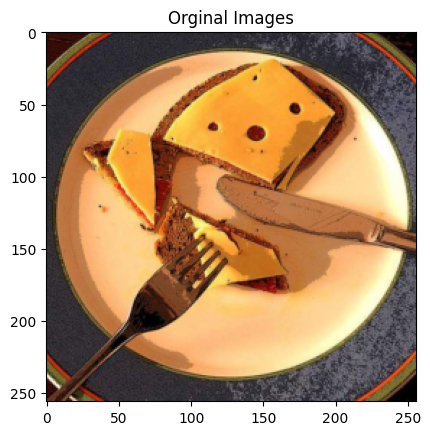

In [42]:
# Example single image
seed = random.randint(0, len(dataset)-1)
org_img, _ = dataset[seed]

plt.imshow(org_img)
plt.title(f"Orginal Images")
plt.show()

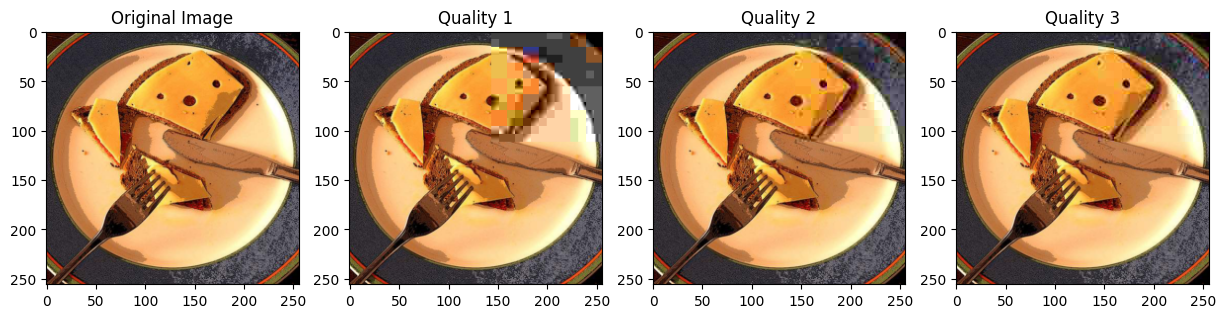

In [43]:
# Example show all levels in 1 row
fig, axes = plt.subplots(1, len(levels_compression)+1, figsize=(15, 5))
org_img, trans_imgs = dataset[seed]

axes[0].imshow(org_img)
axes[0].set_title("Original Image")

for i, img in enumerate(trans_imgs):
    axes[i+1].imshow(img)
    axes[i+1].set_title(f"Quality {i+1}")

In [44]:
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
weight_file = weight_files[0]
print(weight_file)

output_dir = f"results/Attention_maps/transformations/{transform_func_name}/{crop_position}"
# create output_dir if not exists
os.makedirs(output_dir, exist_ok=True)
layer_idx = 5


results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\AIO1.pth


In [45]:
import torch
import numpy as np

def calculate_average_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the average attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Average attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord // patch_size for coord in crop_bbox]

    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]

    # Calculate the average attention in the cropped region
    avg_attention = np.mean(crop_attention)
    
    return avg_attention

def calculate_sum_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the sum of attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Sum of attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord // patch_size for coord in crop_bbox]

    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]

    # Calculate the sum of attention in the cropped region
    sum_attention = np.sum(crop_attention)

    return sum_attention


In [ ]:
attention_data_avg = []
attention_data_sum = []

for image_idx in range(len(dataset)):

    # Creating a subplot
    fig, axes = plt.subplots(len(weight_files)+1, len(levels_compression)*2+1, figsize=((len(levels_compression)*2+1)*5.5, (len(weight_files)+1)*4))

    org_img, trans_imgs = dataset[image_idx]
    org_img_pre = preprocess_img_gray(org_img)

    # Displaying the original image and transformed images in the first row
    axes[0, 0].imshow(org_img)
    axes[0, 0].set_title("Original Image")
    for i, img in enumerate(trans_imgs):
        axes[0, i+1].imshow(img)
        axes[0, i+1].set_title(f"Quality {i+1}")
        diff_img = np.abs(np.array(org_img) - np.array(img))
        axes[0, i+len(trans_imgs)+1].imshow(diff_img)
        axes[0, i+len(trans_imgs)+1].set_title(f"Difference {i+1}")

    # Displaying the attention maps for each weight_file in the next row
    for i, weight_file in enumerate(weight_files):
        model = create_vit_model(weights_path=weight_file)
        model.eval()
        model.to(device)
        weight_name = os.path.basename(weight_file).split('.')[0]

        # Calculate attention maps for the original and transformed images
        img_pre_org = trans_norm2tensor(org_img, image_size, transformation_function=None)
        _, attention_org = get_attention_maps(model, img_pre_org, patch_size, device)
        layer_attention_org = attention_org[layer_idx]
        layer_mean_org = normalize_attention_maps(np.mean(layer_attention_org, axis=0))

        sns.heatmap(layer_mean_org, cmap="inferno", alpha=0.7, ax=axes[i+1, 0])
        axes[i+1, 0].imshow(org_img_pre)
        axes[i+1, 0].set_title(f"{weight_name} Original Att Map")

        # Calculate attention maps for the transformed images
        imgs_pre_trans = [trans_norm2tensor(img, image_size, transformation_function=None) for img in trans_imgs]
        atts_trans = [get_attention_maps(model, img_pre_trans, patch_size, device)[1] for img_pre_trans in imgs_pre_trans]
        layer_atts_trans = [att[layer_idx] for att in atts_trans]
        layer_mean_trans = [normalize_attention_maps(np.mean(layer_att, axis=0)) for layer_att in layer_atts_trans]

        crop_bbox = transformations.get_random_bbox(org_img, crop_size=crop_size, crop_pos=crop_position)
        # Store average attention for each transformation level and weight
        for j, (lmt, img) in enumerate(zip(layer_mean_trans, trans_imgs)):

            # Calculate the sum of attention within the cropped region
            sum_attention = calculate_sum_attention_in_crop(
                attention_map=lmt, 
                crop_bbox=crop_bbox, 
                patch_size=patch_size)

            # Store the data in the dictionary
            attention_data_sum.append({"Transformation Level": f"Q{j+1}", "Attention Sum": sum_attention, "Weight File": weight_name})

            avg_attention = calculate_average_attention_in_crop(
                attention_map=lmt,
                crop_bbox=crop_bbox,  # Bounding box for the cropped area
                patch_size=patch_size
            )
            # Append to attention_data with the transformation level and weight file
            attention_data_avg.append({"Transformation Level": f"Q{j+1}", "Average Attention": avg_attention, "Weight File": weight_name})

            # Plotting attention maps as done previously
            sns.heatmap(lmt, cmap="inferno", alpha=0.7, ax=axes[i+1, j+1])
            axes[i+1, j+1].imshow(preprocess_img_gray(img))
            axes[i+1, j+1].set_title(f"{weight_name} Q{j+1} Attention Map")

            diff_att = (lmt - layer_mean_org)
            diff_att_round = np.round(diff_att, 2)
            sns.heatmap(diff_att_round, cmap="seismic", alpha=0.7, ax=axes[i+1, j+len(trans_imgs)+1], vmin=-1, vmax=1)
            axes[i+1, j+len(trans_imgs)+1].imshow(preprocess_img_gray(img))
            axes[i+1, j+len(trans_imgs)+1].set_title(f"{weight_name} Diff Q{j+1} Attention Map")
        
        # Clear the model from memory
        del model

    # Adjust layout of subplots
    plt.tight_layout()
    # Define output path
    output_path = os.path.join(output_dir, f"attention_map_comparison_patch_transformation_{transform_func_name}_img_{image_idx}_layer_{layer_idx}_.png")
    print(f"Saving image to {output_path}")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

# Create a DataFrame for boxplot
attention_df_sum = pd.DataFrame(attention_data_sum)
attention_df_avg = pd.DataFrame(attention_data_avg)

In [ ]:
# Get ylim max of all weightfile

ylim_max = attention_df_sum["Attention Sum"].max()

# Generate a boxplot for each weight file
for weight_name in attention_df_sum["Weight File"].unique():
    plt.figure(figsize=(8, 12))
    sns.boxplot(x="Transformation Level", y="Attention Sum", data=attention_df_sum[attention_df_sum["Weight File"] == weight_name])
    plt.ylim(0, ylim_max)
    # plt.yticks(np.arange(0, ylim_max + 0.1, 0.1))
    plt.xlabel("Transformation Level")
    plt.ylabel("Attention Sum")
    plt.title(f"Sum of Attention in Cropped Region for Each Transformation Level ({weight_name})")

    filename = f"boxplot_{crop_position}_patch_transformation_{transform_func_name}_sum_attention_layer_{layer_idx}_weight_{weight_name}.png"
    output_path = os.path.join(output_dir, filename)
    print(f"Saving boxplot to {output_path}")
    plt.savefig(output_path, dpi=300)
    plt.show()

In [ ]:
# Generate a boxplot for each weight file
for weight_name in attention_df_avg["Weight File"].unique():
    plt.figure(figsize=(8, 12))
    sns.boxplot(x="Transformation Level", y="Average Attention", data=attention_df_avg[attention_df_avg["Weight File"] == weight_name])
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Transformation Level")
    plt.ylabel("Average Attention")
    plt.title(f"Average Attention in Cropped Region for Each Transformation Level ({weight_name})")

    filename = f"boxplot_{crop_position}_patch_transformation_{transform_func_name}_avg_attention_layer_{layer_idx}_weight_{weight_name}.png"
    output_path = os.path.join(output_dir, filename)
    print(f"Saving boxplot to {output_path}")
    plt.savefig(output_path, dpi=300)
    plt.show()

-----------------------------------

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Funktion zum Visualisieren eines einzelnen Bildes mit seinen Transformationen
def visualize_image_and_transformations(dataset, image_idx=0):
    # Anzahl der Crop-Positionen und das Originalbild
    n_cols = len(dataset.crop_positions) + 1  # +1 für das Originalbild
    
    # Das erste Bild aus dem Dataset auswählen und alle Transformationen anwenden
    fig, axes = plt.subplots(1, n_cols, figsize=(15, 5))
    
    # Originalbild anzeigen
    original_img = Image.open(dataset.images[image_idx])
    # Define the transformation including normalization
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256)])
    
    original_img = preprocess(original_img)
    axes[0].imshow(original_img)
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    # Transformierte Bilder für jede Crop-Position anzeigen
    for idx, crop_pos in enumerate(dataset.crop_positions, start=1):
        # Transformation anwenden (hier nehmen wir die erste Transformation und den ersten Level als Beispiel)
        transformed_img, *_ = dataset[image_idx * len(dataset.transforms_per_image) + idx - 1]
        
        # Bild anzeigen
        axes[idx].imshow(transformed_img)
        axes[idx].set_title(f"Crop: {crop_pos}")
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualisieren des Bildes und seiner Transformationen
visualize_image_and_transformations(dataset, image_idx=19)


In [ ]:
def plot_attention_maps(images_org, images_transformed, weight_paths, output_dir, img_idx, label, mean, std, patch_size, device):
    """
    Plots and saves attention maps of original and transformed images for multiple model weights.

    Parameters:
    - images_org: list of original images
    - images_transformed: list of transformed images
    - weight_paths: list of paths to model weights
    - output_dir: directory to save output images
    - img_idx: index of the image to process
    - label: label of the transformation applied to the images
    - mean: mean for normalization
    - std: std for normalization
    - patch_size: patch size for attention map
    - device: device to perform computation on (e.g., 'cuda' or 'cpu')
    """
    image_tensor = transforms.ToTensor()(images_org[img_idx]).to(device)
    image_transformed_tensor = transforms.ToTensor()(images_transformed[img_idx]).to(device)

    # Normalization
    image_tensor = transforms.Normalize(mean=mean, std=std)(image_tensor)
    image_transformed_tensor = transforms.Normalize(mean=mean, std=std)(image_transformed_tensor)

    # Set up figure
    fig, axes = plt.subplots(len(weight_paths) + 1, 3, figsize=(10, 30))  
    for ax in axes.flat:
        ax.axis('off')

    # Plot original, transformed images and difference
    axes[0, 0].imshow(images_org[img_idx])
    axes[0, 0].set_title("Original Image")
    axes[0, 1].imshow(images_transformed[img_idx])
    axes[0, 1].set_title("Transformed Image")
    axes[0, 2].imshow(np.abs(np.array(images_org[img_idx]) - np.array(images_transformed[img_idx])))
    axes[0, 2].set_title("Difference")

    for i, weights_path in enumerate(weight_paths):
        model_number = int(weights_path.split('AIO')[1].split('.pth')[0])
        print(f'Model {model_number}: {weights_path}')

        # Load the model with the specified weights
        model = create_vit_model(weights_path=weights_path)
        model.to(device)
        model.eval()

        with torch.no_grad():

            _, attention = get_attention_maps(model, image_tensor, patch_size, device)
            _, attention_transformed = get_attention_maps(model, image_transformed_tensor, patch_size, device)

            img_gray = preprocess_img_gray(images_org[img_idx])
            img_transformed_gray = preprocess_img_gray(images_transformed[img_idx])

            # Process the attention maps
            layer_attention = attention[5]
            layer_attention_transformed = attention_transformed[5]
            layer_mean = np.mean(layer_attention, axis=0)
            layer_mean_transformed = np.mean(layer_attention_transformed, axis=0)

            # Normalize attention maps
            layer_mean_norm = normalize_attention_maps(layer_mean)
            layer_mean_norm_transformed = normalize_attention_maps(layer_mean_transformed)

            # Plot attention maps
            sns.heatmap(layer_mean_norm, cmap="inferno", alpha=0.7, ax=axes[i + 1, 0], cbar=False)
            axes[i + 1, 0].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i + 1, 0].set_title(f"Att Org Img AIO {model_number}")

            sns.heatmap(layer_mean_norm_transformed, cmap="inferno", alpha=0.7, ax=axes[i + 1, 1], cbar=False)
            axes[i + 1, 1].imshow(img_transformed_gray, cmap='gray', alpha=0.5)
            axes[i + 1, 1].set_title(f"Att Trans Img AIO {model_number}")

            # Calculate and plot the difference
            diff = layer_mean_norm_transformed - layer_mean_norm
            print("Largest difference:", np.sort(diff.flatten())[-1])
            print("Smallest difference:", np.sort(diff.flatten())[0])

            sns.heatmap(diff, cmap="seismic", alpha=0.7, ax=axes[i + 1, 2], cbar=False)
            axes[i + 1, 2].imshow(img_gray, cmap='gray', alpha=0.5)
            axes[i + 1, 2].set_title(f"Diff Img AIO {model_number}")

    plt.tight_layout()

    # Save the figure
    output_file = f'attention_maps_{crop_pos}_patch_{label}_img_{img_idx}.png'
    output_path = os.path.join(output_dir, output_file)
    plt.savefig(output_path)
    plt.close(fig)
    print(f"Saved attention maps to {output_path}")


In [ ]:
# Create a list of lists
all_images_blurred = [
    images_blurred_center, 
    images_blurred_topleft, 
    images_blurred_topright, 
    images_blurred_bottomleft, 
    images_blurred_bottomright
]

blur_labels = ["center", "top-left", "top-right", "bottom-left", "bottom-right"]


In [ ]:
# Create a list of lists
images_compressed_levels_center = [
    images_compressed_lvl_2_topleft, 
    images_compressed_lvl_3_topleft
]

lvl_labels = ["lvl_2", "lvl_3"]


In [ ]:
for img_idx, img_trans in enumerate(images_compressed_lvl_1_center):
            plot_attention_maps(images_org, images_transformed, weight_paths, output_dir, img_idx, 'Level 1', mean, std, patch_size, device)

In [ ]:
output_base_dir = 'results/Attention_maps/compressed/topleft'

for images_transformed, label in zip(all_images_blurred, blur_labels):
    # Create output directory if it doesn't exist based on the transformation type
    output_dir = os.path.join(output_base_dir, label)
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each image in the transformed images list
    for img_idx in range(0,len(images_transformed)):
        plot_attention_maps(images_org, images_transformed, weight_paths, output_dir, img_idx, label, mean, std, patch_size, device)

In [ ]:
# TO DO:
# - add 3 different levels of blur and compression
# - calculate the avg attention for all patches inside the transformed area (100x100) of all images
# - plot for each weight file a boxplot which shows 3 different levels of blur/compression and their avg attention (x-axis: blur/compression level, y-axis: avg attention)
# - plot for each weight file a figure with the original image and their attention map aswell as the transformed image in 3 different levels of blur/compression and their attention map (first row: original image, transformed image, transformed image, transformed image) (rows: atts for each weight for each images) (columns: original image, transformed image, transformed image, transformed image)

# 2. Load Dataset

In [ ]:
csv_file = 'assets/Test/Obs0.csv'
dataset_root =  'assets/Test/DSX'
batch_size = 128

### 2.1 Add Augmentation (Transformation)

In [ ]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### 2.2 Loading

In [ ]:
# Initialize dataset loader and test dataset
test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model.to(device)

In [ ]:
image_path_to_check = 'assets/Test/DSX/45737ILSVRC2014_train_00060591.JPEG_I4_Q31.jpeg'
label = test_dataset.get_label_by_image_path(image_path_to_check)
print(f"The label for image '{os.path.basename(image_path_to_check)}' is: {label+1}")

# 3. Evaluate

### Evaluate single weight (AIO)

In [ ]:
# List of different weight files
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO2.pth'
results = []
example_pred_results = []

print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
# Load the model with different weights
model = create_vit_model(weights_path=weight_file)
model.eval()

# init result lists
true_labels = []
test_preds = []
entropies = []
true_entropies =[]
weighted_sums = []
kl_divs = []
with torch.no_grad():

    for i, (images, image_paths, labels) in enumerate(test_loader, 0):
        # images = images.to(device)
        # labels = labels.to(device)
        print(f"Example Prediction of Batch: {i}")
        outputs = model(images)
        true_labels.extend(labels)

        # Convert logits to probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)
        
        # Calculate the true distribution
        true_distributions = calculate_label_distributions(labels,device='cpu')
        # Get predicition by the maximum probability
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        
        formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
        # print(f"Predicted Probabilities:{formatted_probabilities}")
        # print(f'Predicted Label: {preds[0]}')


        # Calculate Entropy
        entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
        true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
        # Format entropies in a readble way
        entropies.extend(entropy_values)
        true_entropies.extend(entropy_values)
        # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

        # Calculate KL Divergence
        kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
        # print(f'KL-Divergence batchmean: {kl_div}')
        kl_divs.append(kl_div.item())
        
        # Define weighting factors
        weighting_factors = [0,1,2,3,4]
        # Calculate the weighted sum of probabilities
        weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
        # Format weighted sum in a readble way
        weighted_sums.extend(weighted_sum)
        # Example printout for the first batch
        if i <=2:
            example_pred_result = {
                "Weights File": os.path.basename(weight_file),
                "Image Name": os.path.basename(image_paths[i]),
                "True Label": labels.cpu().numpy()[i],
                "Predicted Label": preds.cpu().numpy()[i],
                "Weighted Sum of Probability": weighted_sum[i],
                "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                "Entropy Value": entropy_values[i],
                "True Entropy Value": true_entropy_values[i],
                "KL Divergence (batch-mean)": kl_divs[i],
            }
            example_pred_results.append(example_pred_result)
        print(f'True-Label: {labels.cpu()[0]}')
        print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
        print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Weighted Sum of Prob
        print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
        print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
        print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
        print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
        print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



# Calculate the MSE of weighted sum and ground truth
mse_weighted = mean_squared_error(true_labels, weighted_sums)

# Calculate the MSE of most likely class and ground truth
mse = mean_squared_error(true_labels, test_preds)

# Calculate the Mean Entropy
mean_entropy = np.mean(entropies)

# Calculate the Mean KL Divergence
mean_kl_div = np.mean(kl_divs)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, test_preds)
target_names  = ["bad", "poor", "fair", "good", "excellent"]

# Generate classification report
class_report = classification_report(true_labels, test_preds, target_names=target_names)

# Generate confusion matrix
confusion = confusion_matrix(true_labels, test_preds)
print('#'*50)
print('model summary:')
# Save confusion matrix as a figure
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(weight_file.replace(".pth", "_confusion.png"))
plt.close()
result = {
    "Weights File": os.path.basename(weight_file),
    "Accuracy": accuracy,
    "MSE": mse,
    "MSE weighted": mse_weighted,
    "Mean Entropy": mean_entropy,
    "Mean KL Divergence": mean_kl_div, 
    "Classification Report": class_report
}
# Store the results
results.append(result)
# Print summary
for key, value in result.items():
    print(f"{key}: {value}")
print('#'*50)

# Create a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_path = weight_file.replace(".pth", "_model_comparison_results.csv")
results_df.to_csv(results_path, index=False)

# Save example printouts to a CSV file for this model
example_printouts_df = pd.DataFrame(example_pred_results)
example_printout_file = weight_file.replace(".pth", "_model_comparison_results_examples.csv")
example_printouts_df.to_csv(example_printout_file, index=False)

### Cross comparison

In [ ]:
dataset_root = "assets/Test/DSX"
csv_dir = "assets/Test"
csv_files = [os.path.join(csv_dir, f'Obs{i}.csv') for i in range(1,6)]
weight_files = [f'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO{i}.pth'for i in range(6)]

print(csv_files)


In [ ]:
obs = []

for csv_file in csv_files:
    # Initialize dataset loader and test dataset
    test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"loaded dataset due to {os.path.basename(csv_file)}")
    example_pred_results = []
    aio_acc = []

    for weight_file in weight_files:
        print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
        # Load the model with different weights
        model.load_state_dict(torch.load(weight_file))
        model.eval()
        # aio_idx = int(''.join(filter(str.isdigit, os.path.basename(weight_file))))
        # init result lists
        true_labels = []
        test_preds = []

        with torch.no_grad():
            for i, (images,image_paths, labels) in enumerate(test_loader, 0):
                # images = images.to(device)
                # labels = labels.to(device)
                print(f"Example Prediction of Batch: {i}")
                outputs = model(images)
                true_labels.extend(labels)

                # Convert logits to probabilities
                probabilities = nn.functional.softmax(outputs, dim=1)
                 
                if i != 0:
                    true_distributions = calculate_label_distributions(labels,device='cpu')
                else:
                    true_distributions = torch.nn.functional.one_hot(labels, num_classes).float()

                # Get predicition by the maximum probability
                _, preds = torch.max(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())

                print(f'Image Name: {os.path.basename(image_paths[i])}')
                print(f'True-Label: {labels.cpu()[0]}')
                print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')


        # Calculate Accuracy
        accuracy = accuracy_score(true_labels, test_preds)

        print('\n')
        print('#'*50)
        print('model summary:')
        result = {
            "Weights File": os.path.basename(weight_file),
            "Accuracy (accaptable)": round(accuracy,2),
        }
        aio_acc.append(accuracy)
        # Print summary
        for key, value in result.items():
            print(f"{key}: {value}")
        print('#'*50)
        print('\n')

        target_names  = ["bad", "poor", "fair", "good", "excellent"]
        # Generate confusion matrix
        confusion = confusion_matrix(true_labels, test_preds)
        
        # Create a DataFrame from the confusion matrix with target names
        # confusion_df = pd.DataFrame(confusion, index=target_names, columns=target_names)

        # Ensure the confusion matrix has the correct shape (5x5 in this case)
        expected_shape = (len(target_names), len(target_names))

        # Create a DataFrame with zeros and the correct shape
        confusion_df = pd.DataFrame(0, index=target_names, columns=target_names)

        # Update the DataFrame with the values from the provided confusion matrix
        confusion_df.loc[confusion_df.index[:len(confusion)], confusion_df.columns[:len(confusion)]] = confusion



        obs_name, _ = os.path.splitext(os.path.basename(csv_file))
        confusion_path = weight_file.replace(".pth", f"_{obs_name}_confusion.png")
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.savefig(confusion_path)
        plt.close()

    obs.append(aio_acc)


# Create a DataFrame for the obs list with proper headers and index (cross comparison)
cc_df = pd.DataFrame(obs, columns=[f"AIO{i}" for i in range(6)], index=[f"Obs{i}" for i in range(6)])

# Specify the path to save the obs table as a CSV file
cc_path = os.path.join(os.path.dirname(weight_files[0]),"cross_comparison.csv")

# Save the DataFrame to a CSV file
cc_df.to_csv(cc_path)

#### Acceptable Ratio Table

In [ ]:
directory_path = "assets/Test"
csv_files = [f'assets/Test/Obs{i}.csv'for i in range(6)]
# List of weight files
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
weight_files = [f'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO{i}.pth'for i in range(6)]


In [ ]:
obs = [[] for _ in range(len(csv_files))]
for csv_file in csv_files:
    # Initialize dataset loader and test dataset
    test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    obs_idx = int(''.join(filter(str.isdigit, csv_file)))-1
    example_pred_results = []
    aio_acc = [0] * len(weight_files)

    for weight_file in weight_files:
        print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
        # Load the model with different weights
        model.load_state_dict(torch.load(weight_file))
        model.eval()
        aio_idx = int(''.join(filter(str.isdigit, os.path.basename(weight_file))))-1
        # init result lists
        true_labels = []
        test_preds = []

        with torch.no_grad():
            for i, (images,image_paths, labels) in enumerate(test_loader, 0):
                # images = images.to(device)
                # labels = labels.to(device)
                print(f"Example Prediction of Batch: {i}")
                outputs = model(images)
                true_labels.extend(labels)

                # Convert logits to probabilities
                probabilities = nn.functional.softmax(outputs, dim=1)
                 
                if obs_idx != 0 and aio_idx !=0 or obs_idx != 0:
                    # Calculate the true distribution
                    true_distributions = calculate_label_distributions(labels,device='cpu')
                else:
                    true_distributions = torch.nn.functional.one_hot(labels, num_classes).float()

                # Get predicition by the maximum probability
                _, preds = torch.max(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())

                print(f'Image Name: {os.path.basename(image_paths[i])}')
                print(f'True-Label: {labels.cpu()[0]}')
                print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')


        # Calculate Accuracy
        # accuracy = accuracy_score(true_labels, test_preds)
        correct_predictions = sum(1 for true, pred in zip(true_labels, test_preds) if true == pred or abs(true - pred) == 1)
        total_predictions = len(true_labels)
        accuracy = correct_predictions / total_predictions
        print('\n')
        print('#'*50)
        print('model summary:')
        result = {
            "Weights File": os.path.basename(weight_file),
            "Accuracy (accaptable)": round(accuracy,2),
        }
        aio_acc[aio_idx]=accuracy
        # Print summary
        for key, value in result.items():
            print(f"{key}: {value}")
        print('#'*50)
        print('\n')
    obs[obs_idx]=aio_acc


# Create a DataFrame for the obs list with proper headers and index
obs_df = pd.DataFrame(obs, columns=[f"AIO{i}" for i in range(1,6)], index=[f"Obs{i}" for i in range(1,6)])

# Specify the path to save the obs table as a CSV file
obs_path = os.path.join(weights_dir,"cross_comparison_acceptable_ratio.csv")

# Save the DataFrame to a CSV file
obs_df.to_csv(obs_path)

# 4. Plot

### Plot Distributions

In [ ]:
model = create_vit_model()
batch_size = 128

weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]

# dir with images
images_dir = "assets/Test/DSX"

# image_paths = get_image_paths_from_dir(images_dir)
# image_paths = get_image_paths_from_csv('assets/Test/DSX/global_avg.csv', 5)

# select images manually
filenames = ['8034ILSVRC2013_train_00034320.JPEG_I4_Q50.jpeg', '10451ILSVRC2013_train_00058547.JPEG_I1_Q2.jpeg', '4692ILSVRC2013_train_00079353.JPEG_I3_Q22.jpeg', '30442ILSVRC2014_train_00005639.JPEG_I1_Q3.jpeg', '4337ILSVRC2013_train_00018603.JPEG_I1_Q8.jpeg']
image_paths = [os.path.join(images_dir, filename) for filename in filenames]

print(weight_files)
print(image_paths)


#### True Distribution

In [ ]:
true_distribution = calculate_label_distributions([1],device=device).cpu().numpy()[0]
# Create an index for the x-axis
index = range(1, len(true_distribution) + 1)

# Plot the probability distribution
plt.bar(index, true_distribution, tick_label=index)
plt.ylim(0,1)
plt.xlabel('Index')
plt.ylabel('Probabilities')
# Add text labels for each bar
for i in range(len(true_distribution)):
    plt.text(index[i], true_distribution[i], f'{true_distribution[i]:.2f}', ha='center', va='bottom')
plt.title('Probability Distribution')
plt.savefig('Probability Distribution.png')
plt.show()

#### Predicted Distribution

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# Init Matplotlib-Fig
num_weights = len(weight_files)
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, num_weights+1, figsize=(30, 20))

for i in range(len(weight_files)+1):
    if i != 0:
        model.load_state_dict(torch.load(weight_files[i-1]))

    for j, image_path in enumerate(image_paths):
        ax = axes[j,i]
        image = Image.open(image_path)

        if i == 0:  # Only the first column should have images
            # Load the image and display it on the y-axis
            img = prev_img(image, image_size)
            ax.imshow(img)
            ax.set_title('Original Image')
        else:
            img_tensor = trans_norm2tensor(image,image_size)
            img = img_tensor.unsqueeze(0).to(device)
            model.to(device)
            with torch.no_grad():
                model.eval()
                output= model(img)

            probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]            # Adjust x-axis values
            x = np.arange(1, len(probabilities) + 1)
            ax.bar(x, probabilities)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_files[i-1]))[0]}')
            # Set Y-scale from 1 to 0
            ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### Compare

In [ ]:
def standard_deviation(probabilities, num_classes=5):
    """
    Calculate the standard deviation of a distribution represented by probabilities.

    This function computes the standard deviation of a distribution given a list of probabilities
    for each class. It assumes that the probabilities are indexed by class label, starting from 1
    up to the specified number of classes.

    Parameters:
        probabilities (list): A list of probabilities for each class.
        num_classes (int): The total number of classes. Defaults to 5.

    Returns:
        float: The standard deviation of the distribution.

    """
    # Check if the number of probabilities matches the number of classes
    if len(probabilities) != num_classes:
        raise ValueError("Number of probabilities and classes should be the same.")

    # Convert lists to PyTorch tensors
    probabilities_tensor = torch.tensor(probabilities, dtype=torch.float32)
    values_tensor = torch.arange(1, num_classes + 1)

    # Calculate the mean (expectation) of the distribution
    mean = torch.sum(probabilities_tensor * values_tensor)

    # Calculate the squared difference of each value from the mean
    squared_diff = (values_tensor - mean) ** 2

    # Calculate the weighted sum of squared differences
    weighted_sum = torch.sum(probabilities_tensor * squared_diff)

    # Calculate the standard deviation as the square root of the weighted sum
    std_deviation = torch.sqrt(weighted_sum)

    return std_deviation.item()


In [ ]:
def compare_probabilities(label, predicted_probabilities, ax):
    """
    Compare predicted probabilities with true distribution for a given label.

    This function visualizes the predicted probabilities and the true distribution
    for a given label using a bar chart. The predicted probabilities are plotted
    in orange, while the true distribution is plotted in black.

    Parameters:
        label (int): The true label for comparison.
        predicted_probabilities (list or numpy.ndarray): Predicted probabilities for each class.
        ax (matplotlib.axes.Axes): The matplotlib axes object for plotting.

    Returns:
        None
    """
    # Calculate the true distribution for the given label
    true_distribution = calculate_label_distributions(label, device=device)
    true_distribution = true_distribution.cpu().numpy()[0]

    # Set the offset for better visualization
    offset = 0.35

    # Plot the predicted probabilities and true distribution as bar charts
    ax.bar(np.arange(len(predicted_probabilities)), predicted_probabilities, width=0.35, label='predicted', align='center', color='orange')
    ax.bar(np.arange(len(true_distribution)) + offset, true_distribution, width=0.35, label='true', align='center', color='black')

    # Set plot limits, labels, and ticks
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_xticks(np.arange(len(true_distribution)) + offset/2)
    ax.set_xticklabels(np.arange(len(true_distribution)))
    ax.legend()


In [ ]:
csv_dir = 'assets/Test'
csv_files = [os.path.join(csv_dir, f'Obs{i}.csv') for i in range(1,6)]
dataset_root = 'assets/Test/DSX'
num_weights = len(weight_files)
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, num_weights+1, figsize=(4.5 * num_weights+1, 3 * num_images))

for i in range(len(weight_files)+1):
    if i != 0:
        model.load_state_dict(torch.load(weight_files[i-1]))
        dataset = ImageQualityDataset(csv_files[i-1], dataset_root, transform=transform)
    for j, image_path in enumerate(image_paths):
        ax = axes[j,i]
        image = Image.open(image_path)

        if i == 0:  # Only the first column should have images
            # Load the image and display it on the y-axis
            img = prev_img(image, image_size)
            ax.imshow(img)
            ax.set_title('Original Image')
            ax.axis('off')
        else:
            img_tensor = trans_norm2tensor(image,image_size)
            img = img_tensor.unsqueeze(0).to(device)
            model.to(device)
            with torch.no_grad():
                model.eval()
                output= model(img)

            label = dataset.get_label_by_image_path(os.path.join(dataset_root, os.path.basename(image_path)))
            label_tensor = torch.tensor(label).unsqueeze(0).cpu().numpy()

            probabilities = torch.softmax(output, dim=1)
            std_deviation_result = standard_deviation(probabilities[0].cpu().numpy())
            print(f"Standard deviation for image {j+1} and AIO {i}: {std_deviation_result}")
            compare_probabilities(label_tensor, probabilities[0].cpu().numpy(), ax)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_files[i-1]))[0]}')

plt.tight_layout()
plt.show()

### Plot Attention

In [ ]:
image_size = 256
depth = 6
num_classes = 5
patch_size = 16

model = create_vit_model()
print(model)

#### Plot Attention Map of Single AIO

In [ ]:
from misc import transformations

blur_func = transformations.apply_blur_patch
crop_func = transformations.apply_random_crop

In [ ]:
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO5.pth'
image_path = 'assets/Test/DSX/625ILSVRC2013_train_00003983.JPEG_I5_Q95.jpeg'
layer_idx = 5

In [ ]:
import random
# Hilfsfunktion zum Auswählen eines zufälligen Rechtecks im Bild
def get_random_bbox(img, crop_size=(50, 50)):
    """Gibt ein zufälliges Rechteck im Bild zurück."""
    width, height = img.size
    crop_width, crop_height = crop_size
    left = random.randint(0, width - crop_width)
    top = random.randint(0, height - crop_height)
    right = left + crop_width
    bottom = top + crop_height
    return (left, top, right, bottom)

# Transformationen für Teilbereiche definieren
def apply_random_crop(img, crop_size=(50, 50)):
    """Zufälligen Bildausschnitt entfernen und durch Schwarz ersetzen."""
    img = img.copy()
    bbox = get_random_bbox(img, crop_size)
    # Ersetze den Bereich durch eine schwarze Fläche
    img.paste((0, 0, 0), bbox)
    return img

In [ ]:

model = create_vit_model(weights_path=weight_file)
model.eval()
image = Image.open(image_path)
image = prev_img(image, image_size)
# image = crop_func(image, crop_size=(10,10))
image = blur_func(image)
img_pre = trans_norm2tensor(image, image_size, transformation_function=None)
_, attention = get_attention_maps(model, img_pre, patch_size, device)
print(attention.shape)
n_heads = attention.shape[1]
n_layers = attention.shape[0]

img_pre = prev_img(image, image_size, transformation_function=None)
img_gray = prev_img_gray(image, image_size, transformation_function=None)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))  # Create subplots

for ax in axes.flat:
    ax.axis('off')

# Plot the original image
axes[0].imshow(img_pre)
axes[0].set_title("Original Image", fontsize=20, fontname='cmr10')

# Plot the grayscale image with heatmap overlay for Median
layer_attention = attention[layer_idx]
print(layer_attention.shape)

layer_mean = np.mean(layer_attention, axis=0)
layer_mean_norm = normalize_attention_maps(layer_mean)

heatmap = sns.heatmap(layer_mean_norm, cmap="inferno", alpha=0.7, ax=axes[1])
axes[1].imshow(img_gray, cmap='gray', alpha=0.5)
axes[1].set_title("Attention", fontsize=20, fontname='cmr10')
plt.tight_layout()
plt.show()

#### Plot Attention across all layers and all heads (no comparison)

Single AIO

In [ ]:
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO0.pth'
image_path = 'assets/manual_testing_imgs/dark/596ILSVRC2013_train_00009848.JPEG_I5_Q95.jpeg'

model = create_vit_model(weights_path=weight_file)
model.eval()
image = Image.open(image_path)
image = prev_img(image, image_size)
image = transformations.apply_blur_patch(image)
visualize_all_layer_head_attention_maps(model, image, image_size, patch_size, device)

Multiple AIOs

In [ ]:
image_path = 'assets/manual_testing_imgs/focus/637ILSVRC2013_train_00009458.JPEG_I4_Q37.jpeg'
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(0, 6)]

image = Image.open(image_path)
image = prev_img(image, image_size)
image = transformations.apply_blur_patch(image)


for weight_file in weight_files:
    model = create_vit_model(weights_path=weight_file)
    model.eval()
    visualize_all_layer_head_attention_maps(model, image, image_size, patch_size, device)

#### Plot Attention across specific layer (comparison)

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]

images_dir = 'assets/work_imgs/fg_bg'
image_paths = get_image_paths_from_dir(images_dir)

output_dir = 'results/Attention_maps/comparisons'

layer_idx = -1

plot_attention_maps_comparison(weight_files,image_paths, image_size, patch_size,output_dir, layer_idx,device)

#### Plot mean head of all layers for every AIO (compare layers)

No sub

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]
images_dir = 'assets/manual_testing_imgs/blurry'
image_paths = get_image_paths_from_dir(images_dir)

for image_path in image_paths:
    image = Image.open(image_path)
    image = prev_img(image, image_size)
    image = transformations.apply_blur_patch(image)
    get_attention_maps_across_weights(model, image, image_size, patch_size, depth, weight_files, device)

Sub avg (in comparison)

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
images_dir = 'assets/manual_testing_imgs/focus'
num_files = 5
image_paths = get_image_paths_from_dir(images_dir,num_files)
depth = 6

csv_file_path = 'assets/Test/DSX/global_avg.csv'
# image_paths = get_image_paths_from_csv(csv_file_path, num_files)
for image_path in image_paths:
    img = Image.open(image_path)
    # Preprocess the image
    img = prev_img(img, image_size)
    img = transformations.apply_blur_patch(img, crop_size=(100,100))
    get_attention_maps_with_deviation(img, weight_files, image_size,depth, patch_size, device)

#### Plot Attention of Images sorted by global avg

Load Dataset to get global average

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
images_dir = 'assets/Test/DSX'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = -1

# Create a DataLoader
global_avg_dataset = ImageAttentionGlobalAvgDataset(images_dir, weight_files, image_size, patch_size, layer_idx, device)

Write for each image the global avg and path to a csv file 

In [ ]:
csv_file_path = os.path.join(images_dir, 'global_avg.csv')

global_avg_dataset.write_to_csv(csv_file_path)

Get the top 5 images with the highest difference

In [ ]:
# print(f"test: {global_avg_dataset[0]}")
top_5 = global_avg_dataset.get_top_global_avg(5,True)
# print(f"Global Avg: {top_5}")
for i in range(len(top_5)):
    fieldnames = ['filename', 'global_avg', 'org_img', 'att_maps']
    selected_fields = {key: top_5[i][key] for key in fieldnames}
    print(selected_fields)

Get the top 5 images with the lowest difference

In [ ]:
top_5_neg = global_avg_dataset.get_top_global_avg(5,False)

for i in range(len(top_5_neg)):
    fieldnames = ['filename', 'global_avg', 'org_img', 'att_maps']
    selected_fields = {key: top_5_neg[i][key] for key in fieldnames}
    print(selected_fields)

Plot attention of images with highest global avg

In [ ]:
output_dir = 'results/Attention_maps/transformations/grayscale'
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
images_dir = 'assets/Test/DSX'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = 5

# Init figure with axes len(weight_files) x len(top_5)
fig, axes = plt.subplots(nrows=len(top_5)+1, ncols=len(weight_files), figsize=(15, 10))
for ax in axes.flat:
    ax.axis('off')

for i in range(len(top_5)):
    filename = top_5[i]['filename']
    img = top_5[i]['org_img']
    global_avg = top_5[i]['global_avg']
    att_maps = top_5[i]['att_maps']

    # Plot original image
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Global Avg: {global_avg:.4f}')
    axes[0, i].axis('off')
    img_gray = prev_img_gray(img, image_size)
    # Plot attention maps for each weight file
    for j in range(len(weight_files)):
        weight_file = weight_files[j]
        att_map = att_maps[j]
        ax = axes[j+1, i]
        ax.imshow(img_gray)
        sns.heatmap(att_map, cmap="inferno", alpha=0.6, ax=ax, vmin=0, vmax=1)
        ax.set_title(f'{os.path.splitext(os.path.basename(weight_file))[0]} Layer {layer_idx + 1} Attention')

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'attention_maps_highest_differences.png'))
plt.close()


Plot attention of images with lowest global avg

In [ ]:
output_dir = 'results/Attention_maps/transformations/grayscale'
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
images_dir = 'assets/Test/DSX'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = 5

# Init figure with axes len(weight_files) x len(top_5)
fig, axes = plt.subplots(nrows=len(weight_files)+1, ncols=len(top_5_neg), figsize=(15, 10))
for ax in axes.flat:
    ax.axis('off')

print(len(top_5_neg))
for i in range(len(top_5_neg)):
    filename = top_5_neg[i]['filename']
    img = top_5_neg[i]['org_img']
    global_avg = top_5_neg[i]['global_avg']
    att_maps = top_5_neg[i]['att_maps']

    # Plot original image
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Global Avg: {global_avg:.4f}')
    axes[0, i].axis('off')
    img_gray = prev_img_gray(img, image_size)
    # Plot attention maps for each weight file
    for j in range(len(weight_files)):
        weight_file = weight_files[j]
        att_map = att_maps[j]
        ax = axes[j+1, i]
        ax.imshow(img_gray)
        sns.heatmap(att_map, cmap="inferno", alpha=0.6, ax=ax, vmin=0, vmax=1)
        ax.set_title(f'{os.path.splitext(os.path.basename(weight_file))[0]} Layer {layer_idx + 1} Attention')

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'attention_maps_lowest_differences.png'))
plt.close()
